In [1]:
# Import libraries
import moments, moments.LD
import pandas as pd, numpy as np
from collections import defaultdict
import demes, demesdraw, matplotlib.pylab as plt
import msprime as ms

import model, slice, get_LD, plot_LD

### With migration (default)

[Split(parent='Ancestral', children=['Split_01', 'Split_02', 'Split_00'], time=78000.0), Split(parent='Merge_1', children=['Split_11', 'Split_10'], time=60000.0)]


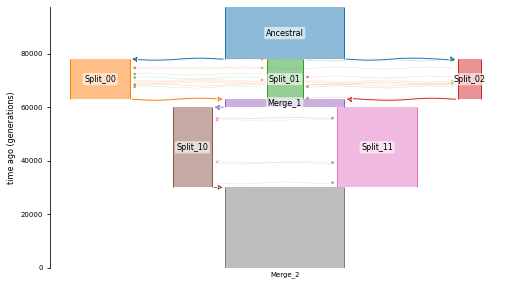

In [24]:
# Create symmetric model
N = 30e3
time_period = 0.1*N
cake = model.cake_model(Ns=[N,N,N],splits = [3,2],proportions=[[1/2,0.3,0.2],[1/3,2/3]],time_period_merge=[time_period,time_period,N],time_period_splits=[0.5*N,N])

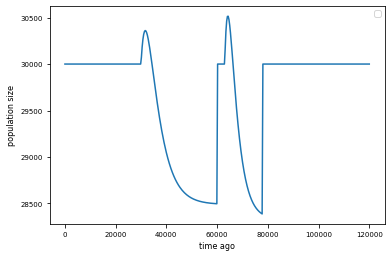

In [25]:
# IIRC
m = ms.Demography.from_demes(cake)
debug = m.debug()

T = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1.2e5, 401)[1:]
])

R, _ = debug.coalescence_rate_trajectory(T, {"Merge_2": 2})

plt.plot(T, 1/(2*R))
plt.legend()
plt.xlabel("time ago")
plt.ylabel("population size");

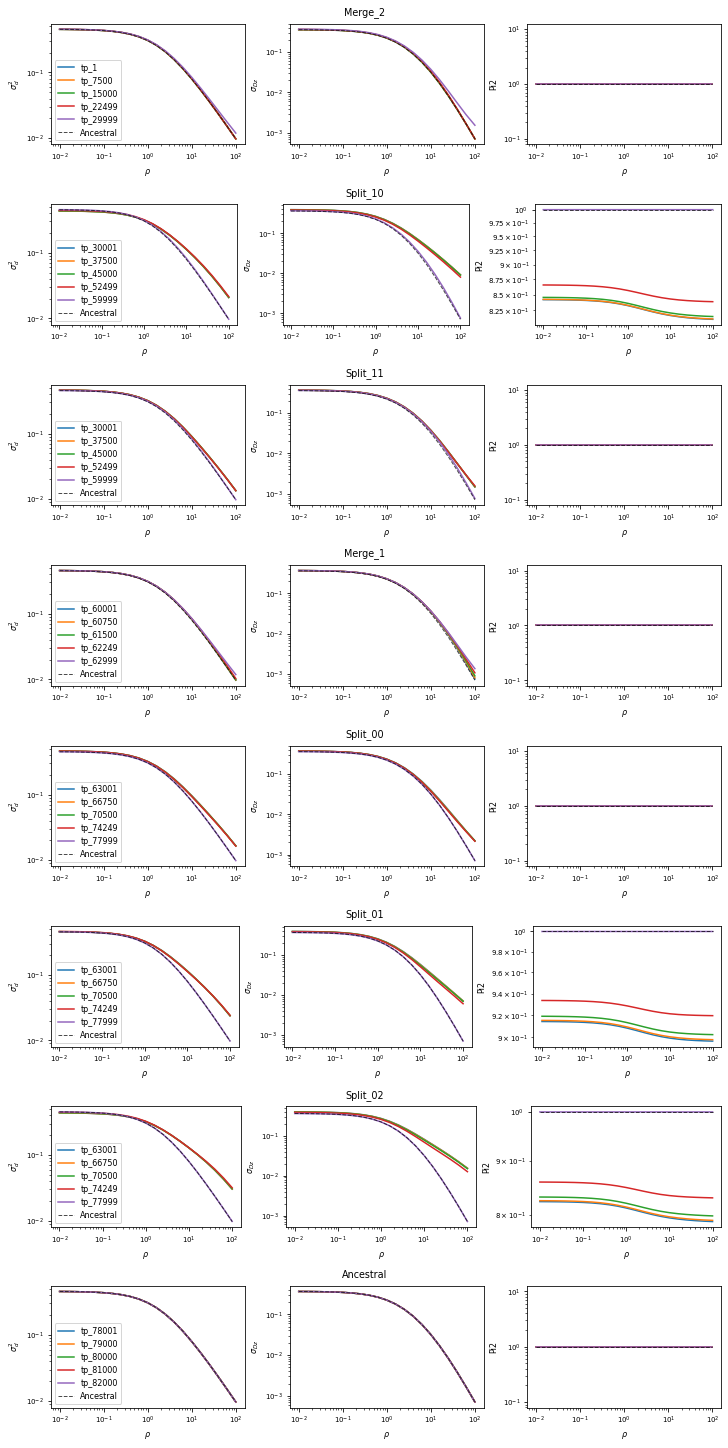

In [17]:
# Slice
times,times_dic = slice.sample_timepoints(cake,time_points_perdeme=5)
sliced_dict = slice.slice_timepoints(cake,times)
# Compute LD
LD_dict = get_LD.get_LD_from_sliced_demes(sliced_dict)
#Plot LD
rhos = np.logspace(-2, 2, 21)
plot_LD.plot_LD(LD_dict,times_dic,LD_dict['Ancestral'][0],rhos,plot_file="../Figures/nonsymmetric_cake/nonsymmetric_3tier_3to2_longertimes_LD.pdf")

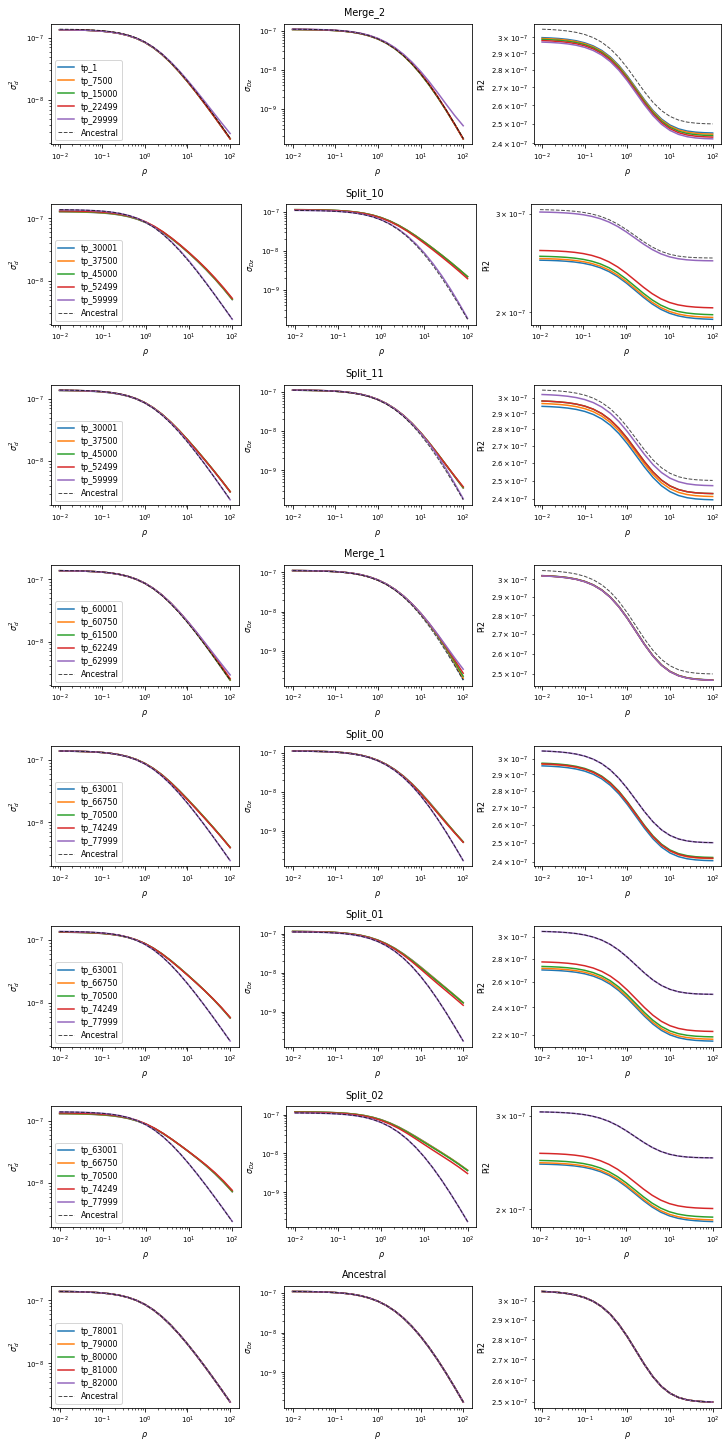

In [6]:
# Compute LD - not normalized
LD_dict = get_LD.get_LD_from_sliced_demes(sliced_dict,normalize=False)
plot_LD.plot_LD(LD_dict,times_dic,LD_dict['Ancestral'][0],rhos,plot_file="../Figures/nonsymmetric_cake/nonsymmetric_3tier_3to2_longertimes_notnorm_LD.pdf")

### Without Migration

[Split(parent='Ancestral', children=['Split_01', 'Split_02', 'Split_00'], time=78000.0), Split(parent='Merge_1', children=['Split_11', 'Split_10'], time=60000.0)]


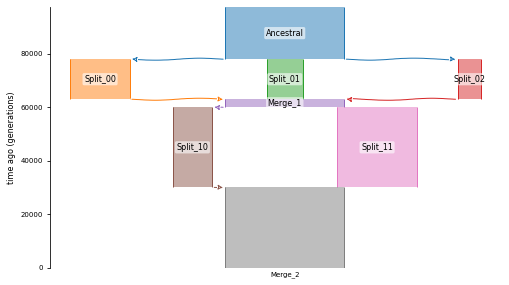

In [19]:
# Create symmetric model
N = 30e3
time_period = 0.1*N
cake = model.cake_model(Ns=[N,N,N],splits = [3,2],proportions=[[1/2,0.3,0.2],[1/3,2/3]],migration_rate=0,time_period_merge=[time_period,time_period,N],time_period_splits=[0.5*N,N])

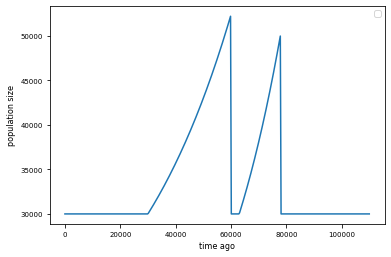

In [23]:
# IIRC
m = ms.Demography.from_demes(cake)
debug = m.debug()

T = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1.1e5, 401)[1:]
])

R, _ = debug.coalescence_rate_trajectory(T, {"Merge_2": 2})

plt.plot(T, 1/(2*R))
plt.legend()
plt.xlabel("time ago")
plt.ylabel("population size");

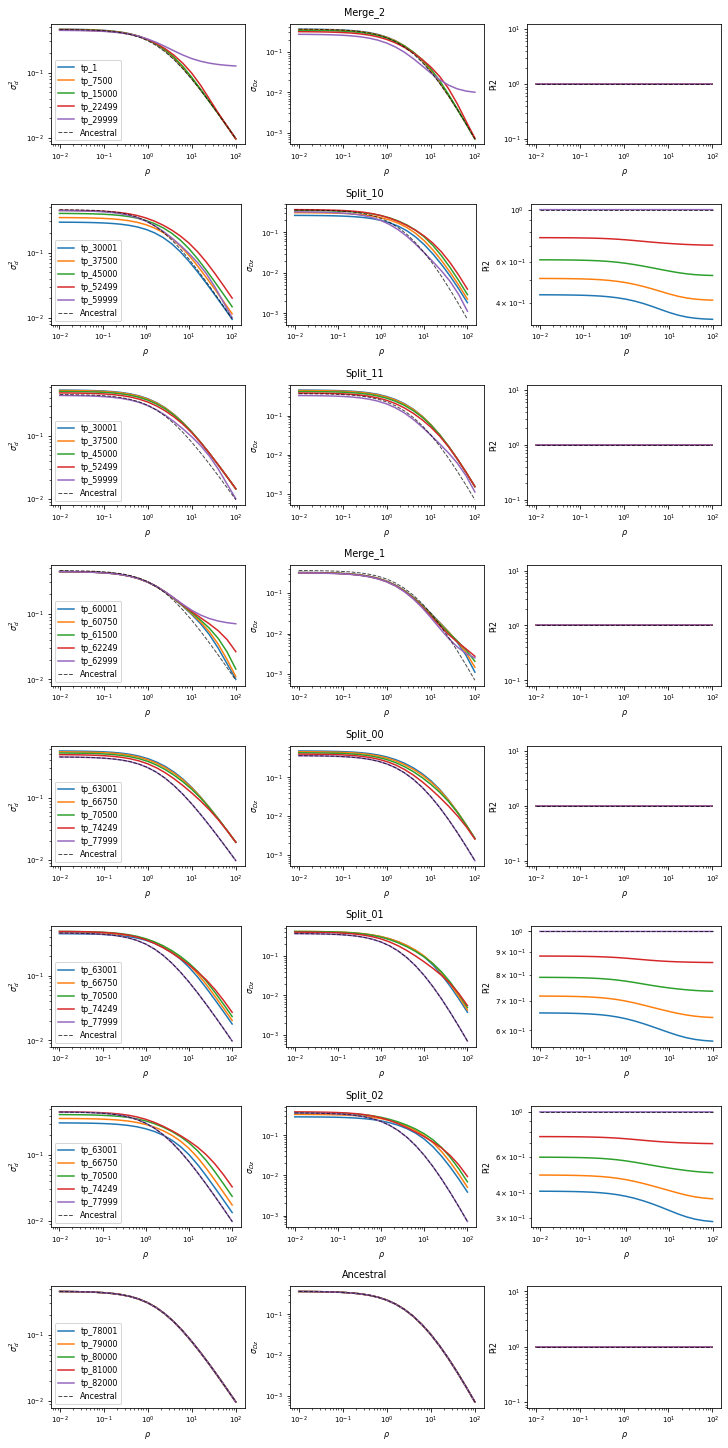

In [8]:
# Slice
times,times_dic = slice.sample_timepoints(cake,time_points_perdeme=5)
sliced_dict = slice.slice_timepoints(cake,times)
# Compute LD
LD_dict = get_LD.get_LD_from_sliced_demes(sliced_dict)
#Plot LD
rhos = np.logspace(-2, 2, 21)
plot_LD.plot_LD(LD_dict,times_dic,LD_dict['Ancestral'][0],rhos,plot_file="../Figures/nonsymmetric_cake/nonsymmetric_3tier_3to2_longertimes_LD_nomigration.pdf")

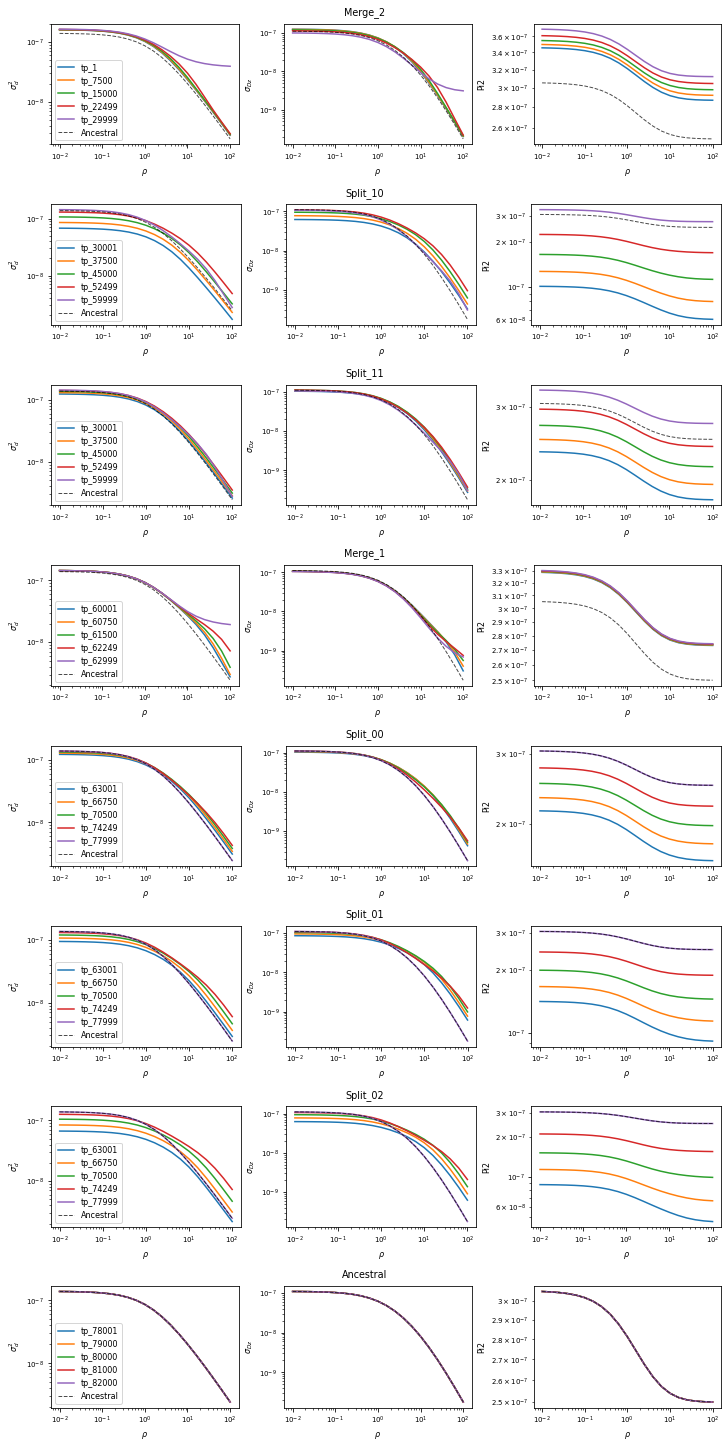

In [9]:
# Compute LD - not normalized
LD_dict = get_LD.get_LD_from_sliced_demes(sliced_dict,normalize=False)
plot_LD.plot_LD(LD_dict,times_dic,LD_dict['Ancestral'][0],rhos,plot_file="../Figures/nonsymmetric_cake/nonsymmetric_3tier_3to2_longertimes_LD_nonorm_nomigration.pdf")

[Split(parent='Ancestral', children=['Split_01', 'Split_00'], time=130000.0)]


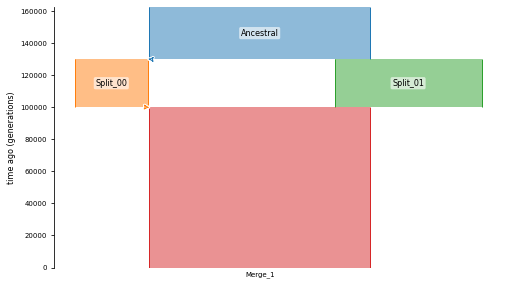

In [6]:
# 1 to 2 no migration
N = 30e3
cake = model.cake_model(Ns=[N,N],splits = [2],proportions=[[1/3,2/3]],migration_rate=0,time_period_merge=[0.7*N,100000],time_period_splits=[N])

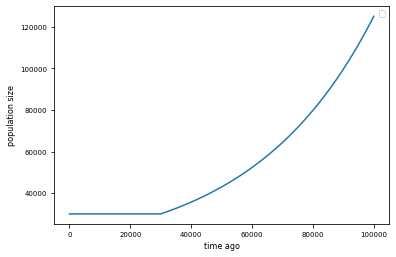

In [3]:
# IIRC
m = ms.Demography.from_demes(cake)
debug = m.debug()

T = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1e5, 401)[1:]
])

R, _ = debug.coalescence_rate_trajectory(T, {"Merge_1": 2})
IIRC = 1/(2*R)

plt.plot(T, 1/(2*R))
plt.legend()
plt.xlabel("time ago")
plt.ylabel("population size");

In [ ]:
previous_N = N
Ns = []
times = []
for N,time in zip(np.flip(1/(2*R)),np.flip(T)):
    if int(N) != previous_N:
        print(previous_N,time)
        Ns.append(previous_N)
        times.append(time)
        previous_N = int(N)

In [67]:
# Population N change model
def get_N_times_from_IIRC(IIRC,T):
    previous_N = IIRC[0]
    Ns = []
    times = []
    for N,time in zip(np.flip(IIRC),np.flip(T)):
        if int(N) != previous_N:
            Ns.append(previous_N)
            times.append(time)
            previous_N = int(N)
    return Ns,times

def size_change_from_IIRC(IIRC,T,yaml_filename=None,plot=True,plot_filename=None):
    
    Ns,times = get_N_times_from_IIRC(IIRC,T)
    
    m = demes.Builder()

    #current_time=np.array(time_period).sum()

    epochs = []
    for N,time in zip(Ns,times):
        epoch = dict(start_size=N,end_time=time)
        epochs.append(epoch)

    m.add_deme("Deme",epochs=epochs)

    # Resolve model
    graph = m.resolve()

    # option to save to yaml
    if yaml_filename != None:
        demes.dump(graph, yaml_filename, format='yaml', simplified=True)
    
    if plot:
        p = demesdraw.tubes(graph, log_time=False, num_lines_per_migration=3)
        if plot_filename != None:
            p.figure.savefig(plot_filename+".svg")
    
    return graph 

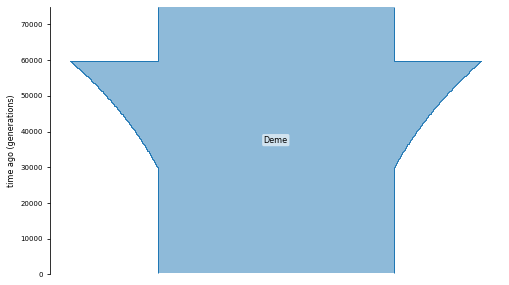

In [68]:
model_from_IIRC = size_change_from_IIRC(1/(2*R),T)

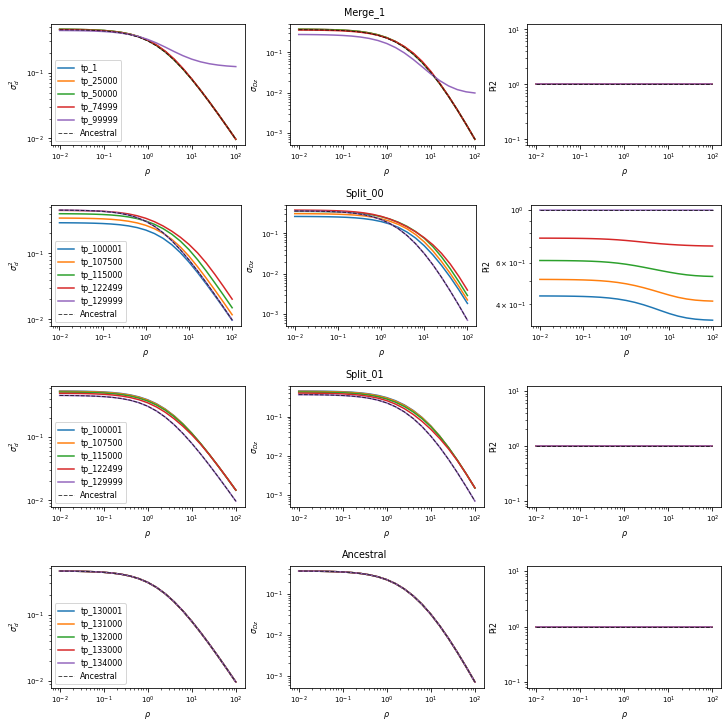

In [9]:
# Slice
times,times_dic = slice.sample_timepoints(cake,time_points_perdeme=5)
sliced_dict = slice.slice_timepoints(cake,times)
# Compute LD
LD_dict = get_LD.get_LD_from_sliced_demes(sliced_dict)
#Plot LD
rhos = np.logspace(-2, 2, 21)
plot_LD.plot_LD(LD_dict,times_dic,LD_dict['Ancestral'][0],rhos,figsize=(10,10),plot_file="../Figures/nonsymmetric_cake/nonsymmetric_3tier_1to2_longertimes_LD_nomigration.pdf")


In [ ]:
# def plot_LD(LD_sigma, times_dic, ancestral, rhos = np.logspace(-2, 2, 21), plot_file = None, figsize = (10,20)):
    fig = plt.figure(constrained_layout=True, figsize = figsize)
    subfigs = fig.subfigures(nrows=len(LD_sigma.keys()), ncols=1)

    for pop,subfig in zip(LD_sigma,subfigs):
        subfig.suptitle(pop)
        (ax1, ax2, ax3) = subfig.subplots(nrows=1, ncols=3)
        for time_point in range(len(LD_sigma[pop])):
            ax1.plot(rhos, LD_sigma[pop][time_point][:, 0],label=str("tp_"+str(times_dic[pop][time_point])))
            ax2.plot(rhos, LD_sigma[pop][time_point][:, 1],label=str("tp_"+str(times_dic[pop][time_point])))
            ax3.plot(rhos, LD_sigma[pop][time_point][:, 2],label=str("tp_"+str(times_dic[pop][time_point])))
        
        ax1.plot(rhos, ancestral[:, 0],'k--',label="Ancestral",linewidth = 1,alpha = 0.7)
        ax2.plot(rhos, ancestral[:, 1],'k--',label="Ancestral",linewidth = 1,alpha = 0.7)
        ax3.plot(rhos, ancestral[:, 2],'k--',label="Ancestral",linewidth = 1,alpha = 0.7)
    
        ax1.set_yscale("log")
        ax2.set_yscale("log")
        ax3.set_yscale("log")
        ax1.set_xscale("log")
        ax2.set_xscale("log")
        ax3.set_xscale("log")
        ax1.set_xlabel(r"$\rho$")
        ax2.set_xlabel(r"$\rho$")
        ax3.set_xlabel(r"$\rho$")
        ax1.set_ylabel(r"$\sigma_d^2$")
        ax2.set_ylabel(r"$\sigma_{Dz}$")
        ax3.set_ylabel(r"Pi2")

        ax1.legend()
        #ax2.legend()
        #ax3.legend()
    if plot_file != None :
        plt.savefig(plot_file,format='pdf',transparent = False)


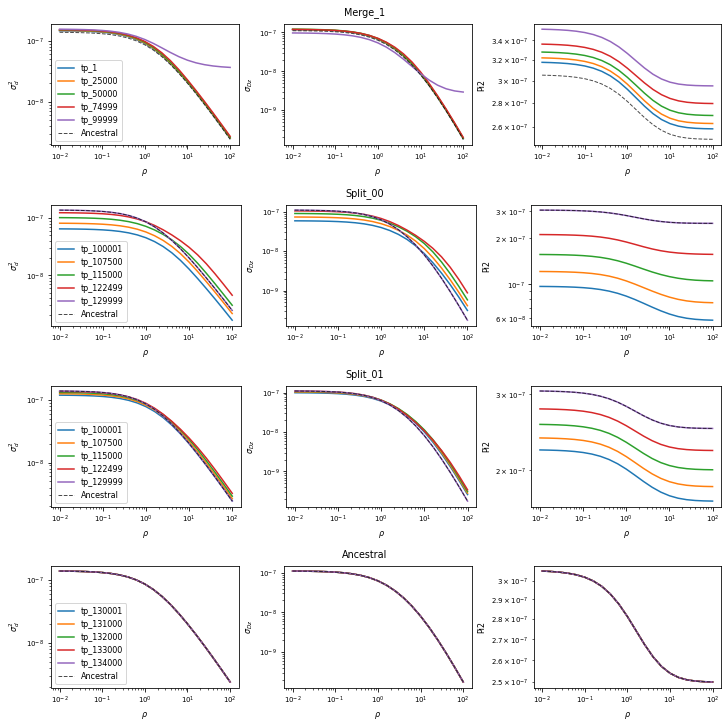

In [8]:
# Compute LD
LD_dict = get_LD.get_LD_from_sliced_demes(sliced_dict,normalize=False)
#Plot LD
rhos = np.logspace(-2, 2, 21)
plot_LD.plot_LD(LD_dict,times_dic,LD_dict['Ancestral'][0],rhos,figsize=(10,10),plot_file="../Figures/nonsymmetric_cake/nonsymmetric_3tier_1to2_longertimes_LD_nonorm_nomigration.pdf")


## Get IIRC curve

### Bottleneck model 

9000.0
6000.0
3000.0
[{'start_size': 30000, 'end_time': 6000.0}, {'start_size': 10000, 'end_time': 3000.0}, {'start_size': 30000, 'end_time': 0.0}]


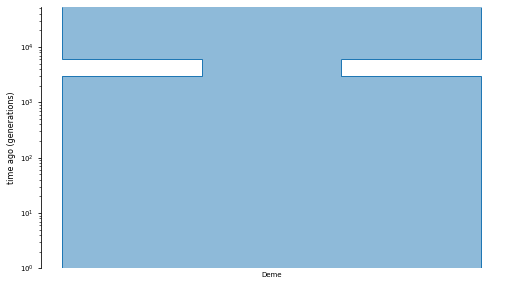

In [8]:
N=30e3
bottleneck = model.size_change(Ns=[30000,10000,30000],time_period=[0.1*N,0.1*N,0.1*N])

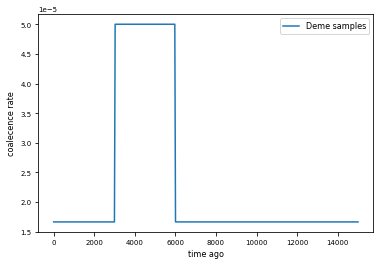

In [9]:
m = ms.Demography.from_demes(bottleneck)
debug = m.debug()

T = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1.5e4, 401)[1:]
])

R, _ = debug.coalescence_rate_trajectory(T, {"Deme": 2})

plt.plot(T, R, label="Deme samples")
plt.legend()
plt.xlabel("time ago")
plt.ylabel("coalecence rate");

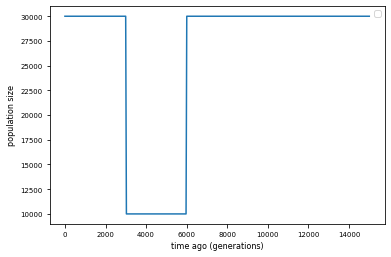

In [10]:
plt.plot(T, 1/(2*R))
plt.legend()
plt.xlabel("time ago (generations)")
plt.ylabel("population size");


### Cake model - bottleneck

In [31]:
cake = model.cake_model(Ns=[N,N],splits=[1],proportions=[[1/3]],time_period_merge=[0.1*N,0.1*N],time_period_splits=[0.1*N],migration_rate=0)

ValueError: deme Merge_1: ancestry proportions must sum to 1.0

In [ ]:
m = ms.Demography.from_demes(bottleneck)
debug = m.debug()

T = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1.5e4, 401)[1:]
])

R, _ = debug.coalescence_rate_trajectory(T, {"Deme": 2})

plt.plot(T, R, label="Deme samples")
plt.legend()
plt.xlabel("time ago")
plt.ylabel("coalecence rate");

In [ ]:
plt.plot(T, 1/(2*R))
plt.legend()
plt.xlabel("time ago (generations)")
plt.ylabel("population size");


### Cake model 1-2-1, symmetrical

[Split(parent='Ancestral', children=['Split_01', 'Split_00'], time=6000.0)]


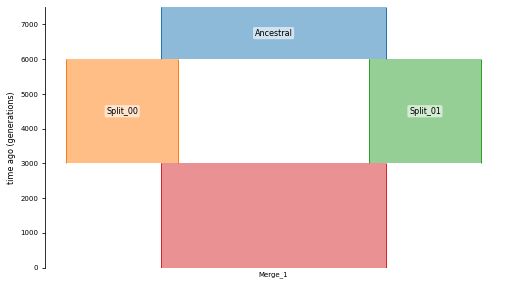

In [12]:
cake = model.cake_model(Ns=[N,N],splits=[2],proportions=[[0.5,0.5]],time_period_merge=[0.1*N,0.1*N],time_period_splits=[0.1*N],migration_rate=0)

In [13]:
m = ms.Demography.from_demes(cake)
debug = m.debug()

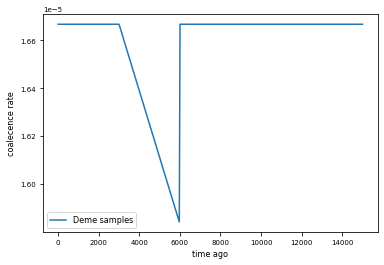

In [14]:
T = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1.5e4, 401)[1:]
])

R, _ = debug.coalescence_rate_trajectory(T, {"Merge_1": 2})

plt.plot(T, R, label="Deme samples")
plt.legend()
plt.xlabel("time ago")
plt.ylabel("coalecence rate");

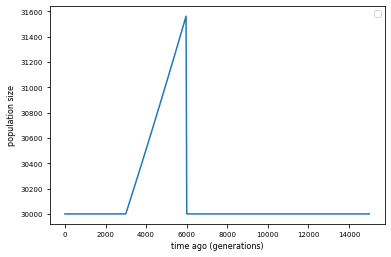

In [15]:
plt.plot(T, 1/(2*R))
plt.legend()
plt.xlabel("time ago (generations)")
plt.ylabel("population size");

### cake model 1-2-1, nonsymmetrical

[Split(parent='Ancestral', children=['Split_01', 'Split_00'], time=6000.0)]


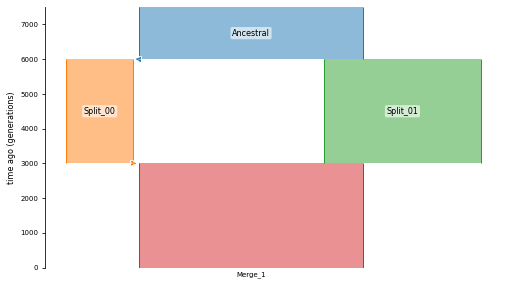

In [16]:
cake4 = model.cake_model(Ns=[N,N],splits=[2],proportions=[[0.3,0.7]],time_period_merge=[0.1*N,0.1*N],time_period_splits=[0.1*N],migration_rate=0)

In [17]:
m = ms.Demography.from_demes(cake4)
debug = m.debug()

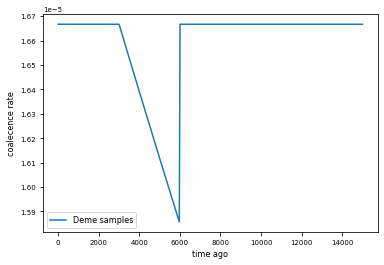

In [18]:
T = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1.5e4, 401)[1:]
])

R, _ = debug.coalescence_rate_trajectory(T, {"Merge_1": 2})

plt.plot(T, R, label="Deme samples")
plt.legend()
plt.xlabel("time ago")
plt.ylabel("coalecence rate");

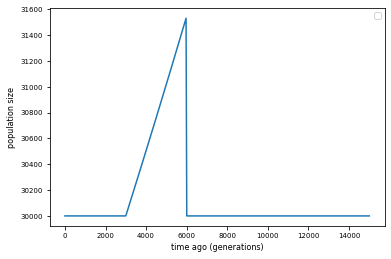

In [19]:
plt.plot(T, 1/(2*R))
plt.legend()
plt.xlabel("time ago (generations)")
plt.ylabel("population size");

### Cake model 1-3-1 , symmetrical

[Split(parent='Ancestral', children=['Split_01', 'Split_00', 'Split_02'], time=6000.0)]


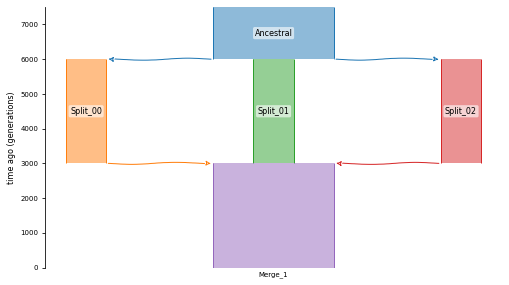

In [20]:
cake2 = model.cake_model(Ns=[N,N],splits=[3],proportions=[[1/3,1/3,1/3]],time_period_merge=[0.1*N,0.1*N],time_period_splits=[0.1*N],migration_rate=0)

In [21]:
m = ms.Demography.from_demes(cake2)
debug = m.debug()

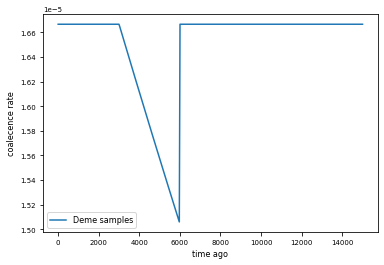

In [22]:
T = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1.5e4, 401)[1:]
])

R, _ = debug.coalescence_rate_trajectory(T, {"Merge_1": 2})

plt.plot(T, R, label="Deme samples")
plt.legend()
plt.xlabel("time ago")
plt.ylabel("coalecence rate");

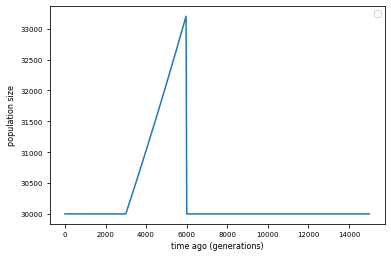

In [23]:
plt.plot(T, 1/(2*R))
plt.legend()
plt.xlabel("time ago (generations)")
plt.ylabel("population size");

### Cake 1-3-1 nonsymmetrical

[Split(parent='Ancestral', children=['Split_01', 'Split_00', 'Split_02'], time=6000.0)]


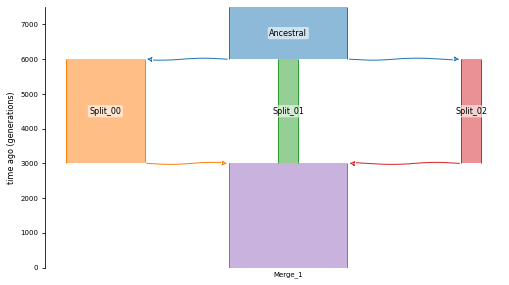

In [26]:
cake3 = model.cake_model(Ns=[N,N],splits=[3],proportions=[[2/3,1/6,1/6]],time_period_merge=[0.1*N,0.1*N],time_period_splits=[0.1*N],migration_rate=0)

In [27]:
m = ms.Demography.from_demes(cake3)
debug = m.debug()

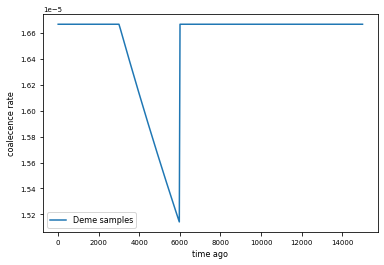

In [28]:
T = np.concatenate([
    np.linspace(0, 1000, 2001),
    np.linspace(1000, 1.5e4, 401)[1:]
])

R, _ = debug.coalescence_rate_trajectory(T, {"Merge_1": 2})

plt.plot(T, R, label="Deme samples")
plt.legend()
plt.xlabel("time ago")
plt.ylabel("coalecence rate");

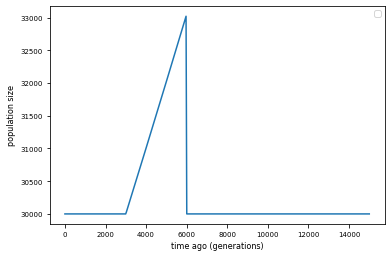

In [29]:
plt.plot(T, 1/(2*R))
plt.legend()
plt.xlabel("time ago (generations)")
plt.ylabel("population size");